In [5]:
!pip install xgboost
!pip install shap

Using basic libraries for calculation, data and modeling.

In [6]:
import numpy as np
import pandas as pd

Check current folder, get updated files if available.

In [7]:
!pwd
#!wget -N https://gitlab.com/dzwietering/corona/-/raw/master/zzprogress.csv
!wget -N https://www.acaps.org/sites/acaps/files/resources/files/acaps_covid19_government_measures_dataset_0.xlsx

/home/zwieteri/git/corona/pydata
--2021-01-08 15:09:24--  https://www.acaps.org/sites/acaps/files/resources/files/acaps_covid19_government_measures_dataset_0.xlsx
Resolving www.acaps.org (www.acaps.org)... 151.80.35.46
Connecting to www.acaps.org (www.acaps.org)|151.80.35.46|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘acaps_covid19_government_measures_dataset_0.xlsx’ not modified on server. Omitting download.



Read the generated country progress file, read the proper columns as dates.

In [8]:
df_prog = pd.read_csv(
    'zzprogress.csv',
    parse_dates=[8, 9, 10])
df_prog

iso2                         cname iso3    ccont     popdata  rsquared  \
0     AD                       Andorra  AND   Europe     76177.0  0.955327   
1     AE          United_Arab_Emirates  ARE     Asia   9770526.0  0.994267   
2     AF                   Afghanistan  AFG     Asia  38041757.0  0.994937   
3     AG           Antigua_and_Barbuda  ATG  America     97115.0  0.983465   
4     AI                      Anguilla  AIA  America     14872.0  0.999319   
..   ...                           ...  ...      ...         ...       ...   
176   VG        British_Virgin_Islands  VGB  America     30033.0  0.960652   
177   VI  United_States_Virgin_Islands  VIR  America    104579.0  0.966921   
178   XK                        Kosovo  XKX   Europe   1798506.0  0.994462   
179   ZA                  South_Africa  ZAF   Africa  58558267.0  0.978311   
180   ZM                        Zambia  ZMB   Africa  17861034.0  0.995188   

     progress          final      start       peak      floor       beta  \
0    1.144845     637.141572 2020-03-18 2020-03-31 2020-05-15   6.149978   
1    0.661986   48966.287562 2020-03-22 2020-05-12 2020-09-25  25.832777   
2    0.175031   74902.586458 2020-04-18 2020-06-25 2020-11-27  39.706238   
3    0.990205      23.660322 2020-03-23 2020-04-05 2020-05-02   7.927177   
4    0.619629       2.074973 2020-03-29 2020-04-05 2020-04-22   5.028065   
..        ...            ...        ...        ...        ...        ...   
176  0.730127       8.217750 2020-03-28 2020-04-27 2020-06-20  22.522308   
177  0.783359      48.873759 2020-03-17 2020-04-17 2020-06-19  20.170511   
178  0.934180    1120.462905 2020-03-21 2020-04-18 2020-06-18  16.975078   
179  0.035563  776113.913893 2020-04-05 2020-09-11 2021-11-02  81.831457   
180  1.085406     935.923468 2020-05-11 2020-05-17 2020-05-30   5.663459   

             mu        maxcur  
0     91.156126    439.684610  
1    132.896521   9642.257985  
2    176.920979   9664.442637  
3     95.526352     13.604608  
4     96.353654      1.613909  
..          ...           ...  
176  117.520926      1.848767  
177  107.945431     12.230366  
178  108.853127    330.460600  
179  254.968956  48963.953211  
180  138.281355    680.472542  

[181 rows x 14 columns]

Have a look at the countries with the highest estimated part of the population concurrently infected. Therefore, we divide the maximum current from the estimate by the population data. We use a log scale due to large differences and show countries with values above 1 per thousand.

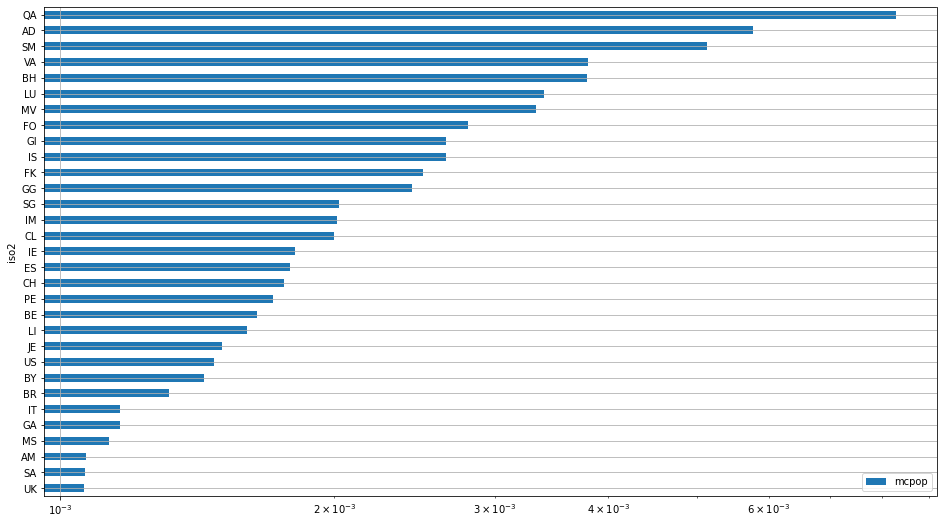

In [9]:
df_prog['mcpop'] = df_prog['maxcur'] / df_prog['popdata']
df_prog[df_prog['mcpop'] > 1/1000].sort_values(by=['mcpop']).plot(
    x='iso2',
    y='mcpop',
    kind='barh',
    logx=True,
    figsize=(16, 9),
    grid=True)

The log of infected seems a good initial measure, so we define it as target.

In [10]:
df_prog['target'] = np.log10(df_prog['mcpop'])
df_prog['target'].describe()

count    181.000000
mean      -3.714819
std        0.687463
min       -5.030719
25%       -4.260580
50%       -3.786451
75%       -3.135566
max       -2.082021
Name: target, dtype: float64

For looking at country behavior we try the ACAPS government measures dataset.

In [11]:
df_meas = pd.read_excel(
    'acaps_covid19_government_measures_dataset_0.xlsx',
    sheet_name='Dataset',
    parse_dates=[12, 16])
df_meas

ID  ISO      COUNTRY  REGION ADMIN_LEVEL_NAME  PCODE  \
0        4245  AFG  Afghanistan    Asia              NaN    NaN   
1        4246  AFG  Afghanistan    Asia              NaN    NaN   
2        4247  AFG  Afghanistan    Asia              NaN    NaN   
3        4248  AFG  Afghanistan    Asia              NaN    NaN   
4          23  AFG  Afghanistan    Asia              NaN    NaN   
...       ...  ...          ...     ...              ...    ...   
23918   13724  ZWE     Zimbabwe  Africa              NaN    NaN   
23919   14735  ZWE     Zimbabwe  Africa              NaN    NaN   
23920   14734  ZWE     Zimbabwe  Africa              NaN    NaN   
23921   13723  ZWE     Zimbabwe  Africa              NaN    NaN   
23922  138074  ZWE     Zimbabwe  Africa              NaN    NaN   

                                   LOG_TYPE                CATEGORY  \
0      Introduction / extension of measures  Public health measures   
1      Introduction / extension of measures  Public health measures   
2      Introduction / extension of measures   Movement restrictions   
3      Introduction / extension of measures  Public health measures   
4      Introduction / extension of measures   Movement restrictions   
...                                     ...                     ...   
23918  Introduction / extension of measures   Movement restrictions   
23919                     Phase-out measure       Social distancing   
23920                     Phase-out measure       Social distancing   
23921                     Phase-out measure       Social distancing   
23922  Introduction / extension of measures  Public health measures   

                                                 MEASURE TARGETED_POP_GROUP  \
0                                    Awareness campaigns                NaN   
1      Health screenings in airports and border cross...            checked   
2                       International flights suspension            checked   
3      Health screenings in airports and border cross...                NaN   
4                                          Border checks            checked   
...                                                  ...                ...   
23918                        Surveillance and monitoring            checked   
23919          Closure of businesses and public services            checked   
23920          Closure of businesses and public services            checked   
23921                                    Schools closure                NaN   
23922  Health screenings in airports and border cross...            checked   

                                                COMMENTS  NON_COMPLIANCE  \
0      MoPH begins announcements on their facebook to...             NaN   
1      Health teams at airports will check passengers...             NaN   
2                       Flights to China are suspended.              NaN   
3      Health screenings of all passengers at airports.              NaN   
4                           All China and Iran nationals             NaN   
...                                                  ...             ...   
23918  Identification/travel documents of returness w...  Not available    
23919  Safari Operators for local hunting only and Na...  Not applicable   
23920  Restaurants now allowed to serve sit-in meals ...  Not applicable   
23921  the re-opening of schools be moved from the pr...  Not applicable   
23922  Passengers will undergo temperature checks at ...   Not Available   

      DATE_IMPLEMENTED                   SOURCE   SOURCE_TYPE  \
0           2020-01-24         Afghanistan MoPH    Government   
1           2020-01-26         Afghanistan MoPH    Government   
2           2020-01-27         Afghanistan MoPH    Government   
3           2020-01-27         Afghanistan MoPH    Government   
4           2020-02-01              US Embassy     Government   
...                ...                      ...           ...   
23918       2020-06-09  Ministry of 

The dataset contains both start and end of measures, so let's see how they are coded. We filter on introductions for now.

In [12]:
print(df_meas['LOG_TYPE'].unique())
df_meas = df_meas[(df_meas['LOG_TYPE'] == 'Introduction / extension of measures') &
                  (df_meas['DATE_IMPLEMENTED'] < '20200601')]

['Introduction / extension of measures' 'Phase-out measure']


Both datasets contain the three character ISO country code, so we join on those columns.

In [13]:
df_full = pd.merge(
    df_prog,
    df_meas,
    left_on='iso3',
    right_on='ISO')
df_full

iso2                 cname iso3   ccont     popdata  rsquared  progress  \
0      AE  United_Arab_Emirates  ARE    Asia   9770526.0  0.994267  0.661986   
1      AE  United_Arab_Emirates  ARE    Asia   9770526.0  0.994267  0.661986   
2      AE  United_Arab_Emirates  ARE    Asia   9770526.0  0.994267  0.661986   
3      AE  United_Arab_Emirates  ARE    Asia   9770526.0  0.994267  0.661986   
4      AE  United_Arab_Emirates  ARE    Asia   9770526.0  0.994267  0.661986   
...   ...                   ...  ...     ...         ...       ...       ...   
9245   ZM                Zambia  ZMB  Africa  17861034.0  0.995188  1.085406   
9246   ZM                Zambia  ZMB  Africa  17861034.0  0.995188  1.085406   
9247   ZM                Zambia  ZMB  Africa  17861034.0  0.995188  1.085406   
9248   ZM                Zambia  ZMB  Africa  17861034.0  0.995188  1.085406   
9249   ZM                Zambia  ZMB  Africa  17861034.0  0.995188  1.085406   

             final      start       peak  ...  \
0     48966.287562 2020-03-22 2020-05-12  ...   
1     48966.287562 2020-03-22 2020-05-12  ...   
2     48966.287562 2020-03-22 2020-05-12  ...   
3     48966.287562 2020-03-22 2020-05-12  ...   
4     48966.287562 2020-03-22 2020-05-12  ...   
...            ...        ...        ...  ...   
9245    935.923468 2020-05-11 2020-05-17  ...   
9246    935.923468 2020-05-11 2020-05-17  ...   
9247    935.923468 2020-05-11 2020-05-17  ...   
9248    935.923468 2020-05-11 2020-05-17  ...   
9249    935.923468 2020-05-11 2020-05-17  ...   

                                                MEASURE  TARGETED_POP_GROUP  \
0                                     Visa restrictions             checked   
1     Health screenings in airports and border cross...             checked   
2                                       Schools closure                 NaN   
3                     Isolation and quarantine policies             checked   
4     Health screenings in airports and border cross...                 NaN   
...                                                 ...                 ...   
9245                            General recommendations             checked   
9246  Emergency administrative structures activated ...                 NaN   
9247             Strengthening the public health system             checked   
9248                       Domestic travel restrictions             checked   
9249                                     Border closure             checked   

                                               COMMENTS  NON_COMPLIANCE  \
0     entry ban for travellers from Iran (no governm...             NaN   
1     passengers arriving from China will undergo he...             NaN   
2                    schools will be closed for 4 weeks             NaN   
3     Introduction of quarantine policiesfor guests ...             NaN   
4          health sreenings for all passengers arriving             NaN   
...                                                 ...             ...   
9245  Supervising officers should ensure: adherence ...  Not available    
9246  Ministries of General Education and Informatio...  Not applicable   
9247  Number of measures are being taken to ensure s...  Not applicable   
9248  There will be a suspension of public road and ...  Not applicable   
9249  Nakonde Boarder to temporarily close tomorrow ...  Not applicable   

      DATE_IMPLEMENTED                   SOURCE   SOURCE_TYPE  \
0           2020-01-02                  Reuters         Media   
1           2020-01-23             KhaleejTimes         Media   
2           2020-03-08               US Embassy    Government   
3           2020-03-08               US Embassy    Government   
4           2020-03-08               US Embassy    Government   
...                ...                      ...           ...   
9245        2020-03-26              Africa News         Media   
9246        2020-04-13  Ministry of Information  Social media   
9247        2020-04-

The first analysis could be how early measures were implemented, so we calculate the difference between the implemented date and our estimated start date in days.

In [14]:
df_full['days'] = (df_full['DATE_IMPLEMENTED'] - df_full['start']).dt.days
df_full['days'].describe()

count    8939.000000
mean       12.201812
std        33.514240
min      -132.000000
25%        -7.000000
50%        11.000000
75%        36.000000
max       118.000000
Name: days, dtype: float64

To reduce this to a source dataset for modeling, we pivot to columns with the average number of days for categories, indexed by country code.

In [15]:
df_aggr = df_full.pivot_table(
    index='iso2',
    columns='MEASURE',
    values='days',
    aggfunc='mean')
df_aggr

MEASURE  Additional health/documents requirements upon arrival  \
iso2                                                             
AE                                                     NaN       
AF                                                     NaN       
AG                                                     NaN       
AL                                                     NaN       
AM                                                     NaN       
...                                                    ...       
UZ                                                     NaN       
VC                                                     NaN       
VE                                                     NaN       
ZA                                                     NaN       
ZM                                                     NaN       

MEASURE  Amendments to funeral and burial regulations  Awareness campaigns  \
iso2                                                                         
AE                                                NaN            43.000000   
AF                                                NaN           -51.857143   
AG                                                5.0           -15.000000   
AL                                                NaN            -3.000000   
AM                                                NaN           -37.000000   
...                                               ...                  ...   
UZ                                                NaN                  NaN   
VC                                                NaN            -6.666667   
VE                                                NaN           -64.000000   
ZA                                                NaN                  NaN   
ZM                                                NaN                  NaN   

MEASURE  Border checks  Border closure  Changes in prison-related policies  \
iso2                                                                         
AE                 NaN             NaN                                 NaN   
AF               -62.5           -54.0                               -18.0   
AG                 NaN             3.0                                 5.0   
AL                 NaN             4.5                                 9.5   
AM                 NaN             4.0                                 NaN   
...                ...             ...                                 ...   
UZ                 NaN             NaN                                 NaN   
VC                 NaN             NaN                                 NaN   
VE                -7.0             NaN                                 NaN   
ZA                 NaN           -20.0                                33.0   
ZM                 NaN             0.0                                 NaN   

MEASURE  Checkpoints within the country  \
iso2                                      
AE                                  NaN   
AF                                  NaN   
AG                                  NaN   
AL                                 -4.0   
AM                                 42.0   
...                                 ...   
UZ                                  NaN   
VC                                  NaN   
VE                                -65.0   
ZA                                  NaN   
ZM                                  NaN   

MEASURE  Closure of businesses and public services  Complete border closure  \
iso2                                                                          
AE                                            30.0                      NaN   
AF                                             NaN                      NaN   
AG                                            14.2                      NaN   
AL                                            -4.0                      NaN   
AM                                            41.0                      NaN  

The final dataset contains this data combined with our estimates.

In [16]:
df_final = pd.merge(
    df_prog,
    df_aggr,
    left_on='iso2',
    right_index=True)
df_final.reset_index(
    drop=True,
    inplace=True)
df_final

iso2                             cname iso3    ccont     popdata  \
0     AE              United_Arab_Emirates  ARE     Asia   9770526.0   
1     AF                       Afghanistan  AFG     Asia  38041757.0   
2     AG               Antigua_and_Barbuda  ATG  America     97115.0   
3     AL                           Albania  ALB   Europe   2862427.0   
4     AM                           Armenia  ARM   Europe   2957728.0   
..   ...                               ...  ...      ...         ...   
145   UZ                        Uzbekistan  UZB     Asia  32981715.0   
146   VC  Saint_Vincent_and_the_Grenadines  VCT  America    110593.0   
147   VE                         Venezuela  VEN  America  28515829.0   
148   ZA                      South_Africa  ZAF   Africa  58558267.0   
149   ZM                            Zambia  ZMB   Africa  17861034.0   

     rsquared  progress          final      start       peak  ...  \
0    0.994267  0.661986   48966.287562 2020-03-22 2020-05-12  ...   
1    0.994937  0.175031   74902.586458 2020-04-18 2020-06-25  ...   
2    0.983465  0.990205      23.660322 2020-03-23 2020-04-05  ...   
3    0.993561  0.905945    1171.941747 2020-03-14 2020-04-16  ...   
4    0.970087  0.252422   33758.967576 2020-03-08 2020-06-25  ...   
..        ...       ...            ...        ...        ...  ...   
145  0.961278  0.940004    3646.034610 2020-04-08 2020-04-28  ...   
146  0.913497  1.161390      18.450799 2020-03-24 2020-04-13  ...   
147  0.997226  1.200132    1088.094324 2020-05-20 2020-05-25  ...   
148  0.978311  0.035563  776113.913893 2020-04-05 2020-09-11  ...   
149  0.995188  1.085406     935.923468 2020-05-11 2020-05-17  ...   

    Other public health measures enforced  Partial lockdown  \
0                                    21.5         14.500000   
1                                   -50.0        -21.000000   
2                                     5.0         35.333333   
3                                   -50.0         24.500000   
4                                     NaN         27.000000   
..                                    ...               ...   
145                                   NaN               NaN   
146                                  14.0               NaN   
147                                 -35.0        -49.000000   
148                                  30.0               NaN   
149                                   NaN               NaN   

     Psychological assistance and medical social work  \
0                                                 NaN   
1                                                 NaN   
2                                                 NaN   
3                                                 NaN   
4                                                 NaN   
..                                                ...   
145                                               NaN   
146                                               NaN   
147                                               NaN   
148                                              36.0   
149                                               NaN   

     Requirement to wear protective gear in public  Schools closure  \
0                                              7.0            -14.0   
1                                              NaN            -41.0   
2                                             28.0             -8.0   
3                                              NaN             -4.0   
4                                             73.5              1.0   
..                                             ...              ...   
145                                           52.0              NaN   
146                                            NaN             -4.0   
147                                          -37.0            -65.5   
148                                            NaN            -18.0   
149                                            NaN            -52.0   

     State of e

Just a quick check on data, for example the relation between beta (the Gumbel curve width parameter) and the target column.

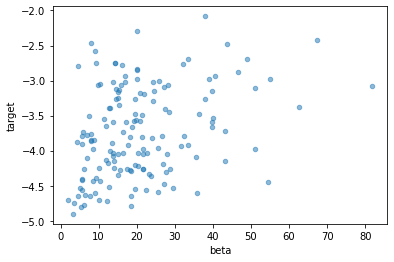

In [17]:
df_final.plot(
    kind="scatter",
    x="beta",
    y="target",
    alpha=1/2)

If we start using this model for predictions, we need to split the dataset. For now we are still exploring so we use all the data for analysis. The feature columns are all the columns added to the right of our dataset with estimations.

In [18]:
featcols = len(df_prog.columns)
features = df_final.columns[featcols:]

#from sklearn.model_selection import train_test_split
#x_trn, x_tst, y_trn, y_tst = train_test_split(df_final[features], df_final['mcpop'])

x_trn = df_final[features]
y_trn = df_final['target']

Create the XGBoost data structure for training and check parameters to prevent overfitting on this small dataset. Then check the error rate between the test and train data used internally by XGBoost. If the test error rate is much higher, we are overfitting.

[0]	train-rmse:3.86978+0.02129	test-rmse:3.86426+0.21044
[10]	train-rmse:1.47724+0.01159	test-rmse:1.47290+0.20281
[20]	train-rmse:0.73402+0.01104	test-rmse:0.74185+0.15840
[30]	train-rmse:0.57100+0.01134	test-rmse:0.60008+0.11068
[40]	train-rmse:0.54298+0.01120	test-rmse:0.58107+0.09464
[50]	train-rmse:0.53735+0.00998	test-rmse:0.57802+0.09319
[60]	train-rmse:0.53462+0.01003	test-rmse:0.57747+0.09168
[70]	train-rmse:0.53275+0.00988	test-rmse:0.57647+0.09355
[80]	train-rmse:0.53269+0.00987	test-rmse:0.57590+0.09220
[90]	train-rmse:0.53212+0.01059	test-rmse:0.57655+0.09163
[99]	train-rmse:0.53214+0.01060	test-rmse:0.57686+0.09159


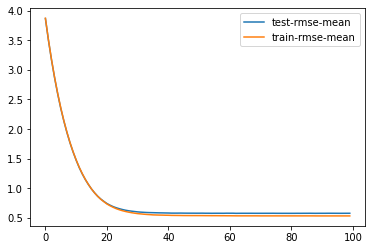

In [19]:
import xgboost as xgb

dtrn = xgb.DMatrix(
    x_trn,
    label=y_trn)
#dtst = xgb.DMatrix(x_tst)

params = {
    #'objective':'reg:squarederror',
    'eta':1/10,
    'gamma':5,
    #'min_child_weight':10,
    #'tree_method':'hist',
    #'seed':0,
    #'max_depth':3,
    'colsample_bytree':0.7,
    'subsample':0.7,
    'nthread':1
}

hist = xgb.cv(
    params,
    dtrn,
    nfold=10,
    as_pandas=True,
    num_boost_round=100,
    verbose_eval=10,
    early_stopping_rounds=1000,
    show_stdv=True,
    seed=0)
hist.plot(y=["test-rmse-mean", "train-rmse-mean"])

Train the model using the parameters found above and show the feature importance. Note that this can be both a positive and negative influence.

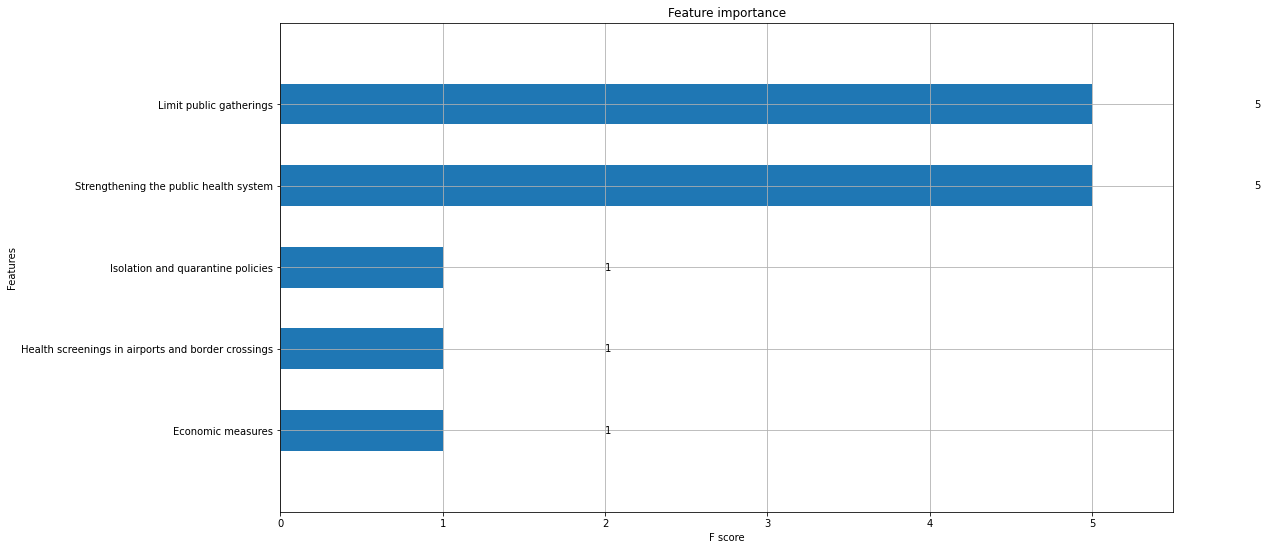

In [20]:
bst = xgb.train(
    params,
    dtrn,
    num_boost_round=100,
    verbose_eval=1)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 9))

xgb.plot_importance(bst, ax=ax, height=1/2)

The actual XGBoost model is an ensemble of decision trees that can be hard to interpret. SHAP is an analysis library that shows the influence of factors based on this model. First we choose a country and see how the estimate relates to measures.

In [21]:
country = 'NL'

rownum = df_final[df_final['iso2'] == country].index[0]

import shap

shap.initjs()

explainer = shap.TreeExplainer(bst, x_trn)
shap_values = explainer.shap_values(x_trn)

shap.force_plot(
    explainer.expected_value,
    shap_values[rownum],
    x_trn.loc[rownum])

When we take all these plots, rotate and stack them we get a global view of the model.

In [22]:
shap.force_plot(
    explainer.expected_value,
    shap_values,
    x_trn)

Looking at individual measures we can visualize their impact on model output.

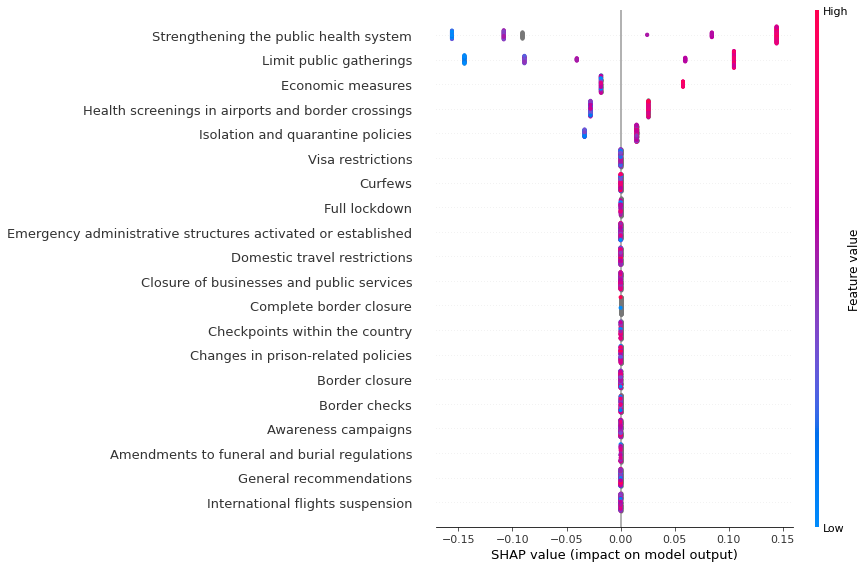

In [23]:
shap.summary_plot(
    shap_values,
    x_trn)

Finally, a similar plot to the importance plot above shows the explanatory value of measures.

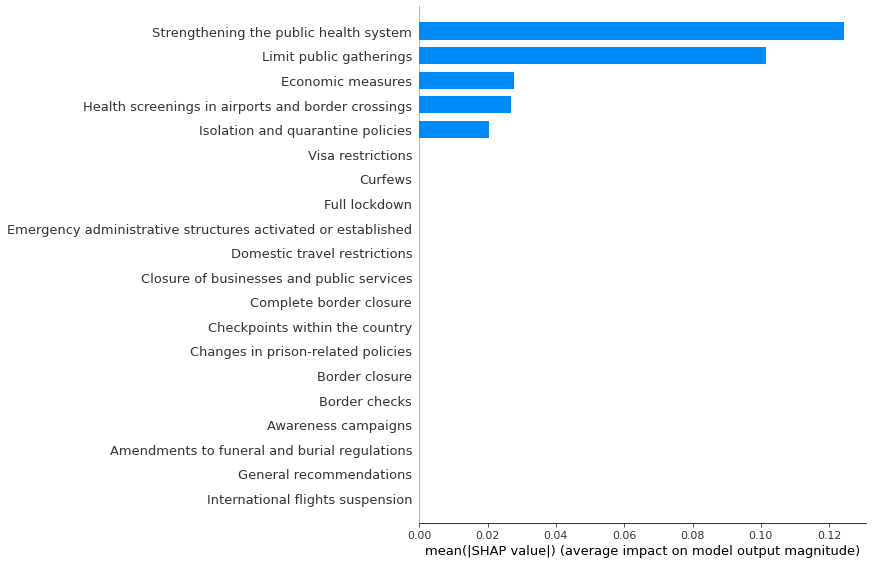

In [24]:
shap.summary_plot(
    shap_values,
    x_trn,
    plot_type="bar")

Keep exploring! Stay home, wash your hands, keep your distance.